In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import mlts

import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
data = mlts.io.merge([
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv')
])

In [3]:
mlts.io.check(data)

In [4]:
K = len(data.iloc[:, 0].value_counts())
ds_train, ds_dev, ds_test, mu, sigma = \
    mlts.io.normalize(mlts.io.split(data, ycol=0, shape=(36086)))

In [5]:
class ClassificationModel(tf.keras.Model):
    def __init__(self, hparams, K):
        super(ClassificationModel, self).__init__(name='classification')
        
        lambd = hparams["lambda"]
        regularization = None
        if (lambd != 0.):
            regularization = tf.keras.regularizers.l2(l=lambd)
        
        self.l1 = tf.keras.layers.Dense(
            128,
            activation=tf.nn.relu,
            kernel_regularizer=regularization
        )
        self.l2 = tf.keras.layers.Dense(
            K,
            activation=tf.nn.softmax,
            kernel_regularizer=regularization
        )

    def call(self, X):
        A = self.l1(X)
        A = self.l2(A)
        return A

In [6]:
class FasionMNISTAdapter(mlts.tf.ModelAdapter):
    def __init__(self, hparams):
        super().__init__(hparams)

    @staticmethod
    def build_model(hparams, metrics = []):
        model = ClassificationModel(hparams=hparams, K=10)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics)
        
        return model
    
    @staticmethod
    def estimate_parameters(hparams, model, ds, epochs, callbacks=[]):
        batch_size = hparams["batch_size"]
        X, y = ds
        
        model.fit(
            tf.data.Dataset.from_tensor_slices(ds).batch(batch_size),
            epochs=epochs,
            shuffle=False,
            callbacks=callbacks
        )
        
        return model

In [7]:
hparams = {"lambda": 0.01, "batch_size": 32}
ad = FasionMNISTAdapter(hparams)
m_hist = ad.analyze_training_examples(ds_train, ds_dev, epochs=1)

W0721 21:26:16.290833 4471154112 deprecation.py:323] From /Users/manifest/projects/github/machine-learning-notebook/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


12000/12000 [==============================] - 0s 30us/sample - loss: 0.4849


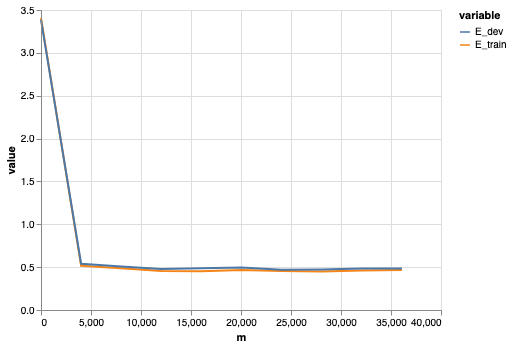

In [8]:
alt.Chart(m_hist.melt(id_vars='m')).mark_line().encode(
    x = 'm',
    y = 'value',
    color = 'variable'
)

In [9]:
ad.fit(ds_train, epochs=10)
E_train = ad.model.history.history["loss"][-1]
E_dev = ad.evaluate(ds_dev)
E_test = ad.evaluate(ds_test)
(E_train, E_dev, E_test)

Epoch 1/10
1128/1128 [==============================] - 3s 3ms/step - loss: 1.1027
Epoch 2/10
1128/1128 [==============================] - 3s 2ms/step - loss: 0.6573
Epoch 3/10
1128/1128 [==============================] - 3s 3ms/step - loss: 0.6474
Epoch 4/10
1128/1128 [==============================] - 3s 3ms/step - loss: 0.6384
Epoch 5/10
1128/1128 [==============================] - 3s 2ms/step - loss: 0.6299
Epoch 6/10
1128/1128 [==============================] - 3s 3ms/step - loss: 0.6233A
Epoch 7/10
1128/1128 [==============================] - 3s 3ms/step - loss: 0.6193
Epoch 8/10
1128/1128 [==============================] - 3s 3ms/step - loss: 0.6151
Epoch 9/10
1128/1128 [==============================] - 3s 2ms/step - loss: 0.6116
Epoch 10/10
12000/12000 [==============================] - 0s 30us/sample - loss: 0.6285


(0.6085458425333711, 0.6231134693622589, 0.62846249071757)